# Dynamic Programming - Group 'Lost in Optimization' - Main python notebook

Install dependencies and set magics:

In [100]:
%load_ext autoreload
%autoreload 2

#%pip install EconModel
#%pip install ConSav
#%pip install quantecon

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
nb.set_num_threads(4) #perhaps set to 8

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial solve of the models

Set amount of periods:

In [101]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','do_print':False})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()

1
0
1
2
0
0
1
2
59
0
1
2
58
0
1
2
57
0
1
2
56
0
1
2
55
0
1
2
54
0
1
2
53
0
1
2
52
0
1
2
51
0
1
2
50
0
1
2
49
0
1
2
48
0
1
2
47
0
1
2
46
0
1
2
45
0
1
2
44
0
1
2
43
0
1
2
42
0
1
2
41
0
1
2
40
0
1
2
39
0
1
2
38
0
1
2
37
0
1
2
36
0
1
2
35
0
1
2
34
0
1
2
33
0
1
2
32
0
1
2
31
0
1
2
30
0
1
2
29
0
1
2
28
0
1
2
27
0
1
2
26
0
1
2
25
0
1
2
24
0
1
2
23
0
1
2
22
0
1
2
21
0
1
2
20
0
1
2
19
0
1
2
18
0
1
2
17
0
1
2
16
0
1
2
15
0
1
2
14
0
1
2
13
0
1
2
12
0
1
2
11
0
1
2
10
0
1
2
9
0
1
2
8
0
1
2
7
0
1
2
6
0
1
2
5
0
1
2
4
0
1
2
3
0
1
2
2
0
1
2
1
0
1
2
0
0
1
2


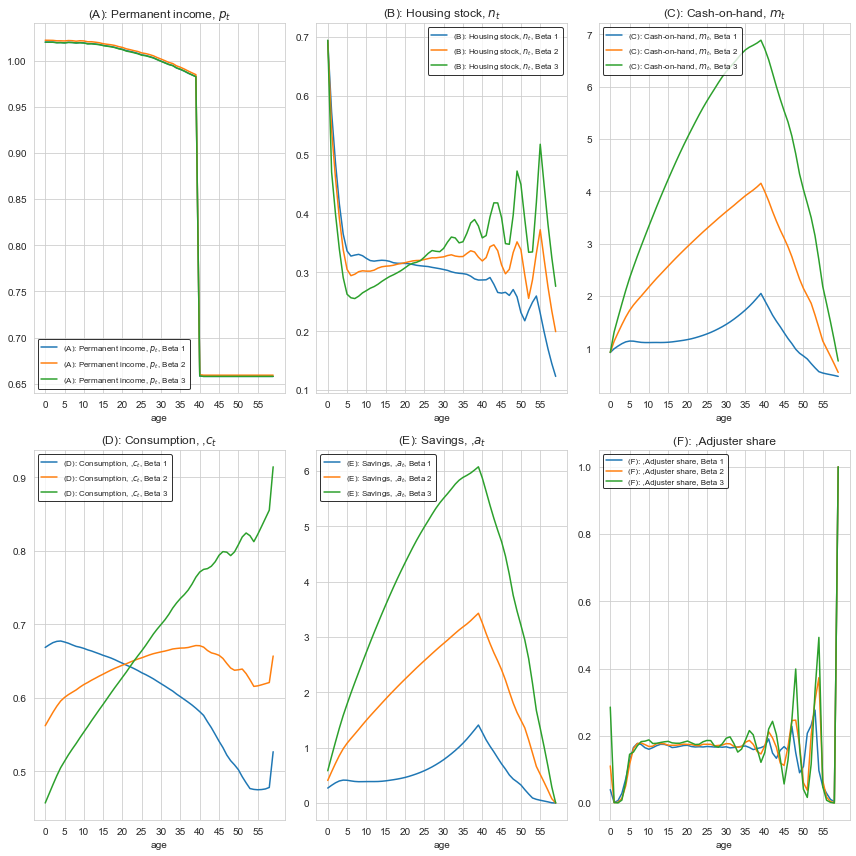

In [103]:
model_negm.lifecycle()

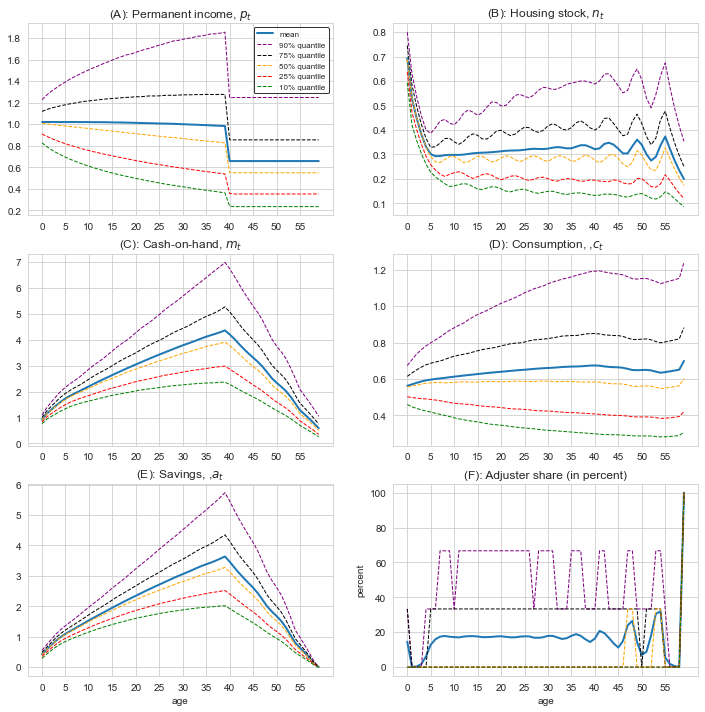

In [108]:
model_negm.lifecycle_rand()

Solve with NVFI

In [107]:
model_nvfi = DurableConsumptionModelClass(name='example_nvfi',par={'solmethod':'nvfi','do_print':False})
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()

1
0
1
2
0
0
1
2
59
0
1
2
58
0
1


Traceback (most recent call last):
  File "/Users/hanschristian/Documents/GitHub/LostInOptimization/Jeppe/02. DurableConsumptionModel/DurableConsumptionModel.py", line 331, in solve
    nvfi.solve_keep(t,b,sol,par)
KeyboardInterrupt


KeyboardInterrupt: 

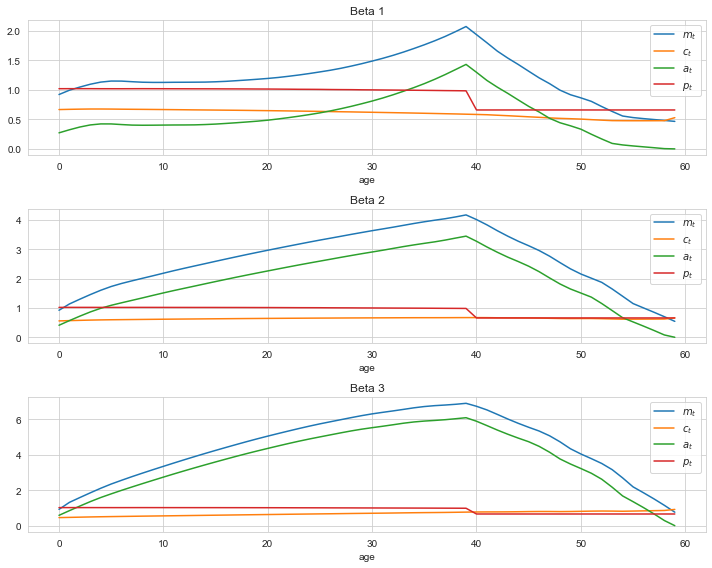

In [ ]:
# a. unpack
par = model_nvfi.par
sim = model_nvfi.sim

# b. figure
fig, axs = plt.subplots(len(par.Betas), 1, figsize=(10, 8))

simvarlist = [('m','$m_t$'),
              ('c','$c_t$'),
              ('a','$a_t$'),
             ('p','$p_t$')]

age = np.arange(par.T)

for b in range(len(par.Betas)):  # loop over beta dimension
    ax = axs[b]  # specify the current subplot

    for simvar, simvarlatex in simvarlist:
        # get simulation data
        simdata = getattr(sim, simvar)

        # calculate mean over individual dimension for each beta
        mean_data = np.mean(simdata[:, b, :], axis=1)

        # plot mean data
        ax.plot(age, mean_data, label=simvarlatex)

    ax.grid(True)
    ax.set_xlabel('age')
    ax.set_title(f'Beta {b+1}')
    ax.legend()

# adjust layout for better visualization
plt.tight_layout()
plt.show()

Solve model with VFI:

In [18]:
model_vfi = DurableConsumptionModelClass(name='example_vfi',par={'solmethod':'vfi','do_print':False})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()

1
0
1
2
0
0
1
2
59
0
1
2
58
0
1


Traceback (most recent call last):
  File "/Users/hanschristian/Documents/GitHub/LostInOptimization/Jeppe/02. DurableConsumptionModel/DurableConsumptionModel.py", line 329, in solve
    vfi.solve_keep(t,b,sol,par,beta)
KeyboardInterrupt


KeyboardInterrupt: 

Now possible to compare solutions:

In [10]:
from figs import lifecycle_compare
lifecycle_compare(model_negm,'negm',model_nvfi,'nvfi')

ImportError: cannot import name 'lifecycle_compare' from 'figs' (/Users/hanschristian/Documents/GitHub/LostInOptimization/Jeppe/02. DurableConsumptionModel/figs.py)

## Timing the model solution methods

### Timing function

In [ ]:
def run(name = 'baseline',
        rep = 5, # set to 5 in the paper
        load = False,
        solmethod = 'negm',
        updpar = {},
        do_simple_wq = False,
        do_print = False):
    
    # a. create model
    par = {'solmethod':solmethod,'do_print':do_print,'do_simple_wq':do_simple_wq,**updpar}
    model = DurableConsumptionModelClass(name=name,load=load,par=par)
    
    # b. run
    if load == False:
        
        model.precompile_numba()        
        
        # ii. best of three
        best_time = np.inf
        for it in range(rep):
            
            model.solve()
            total_time = np.sum(model.par.time_w+model.par.time_keep+model.par.time_adj)
            
            if total_time < best_time:
            
                best_time = total_time
                time_w = model.par.time_w.copy()
                time_keep = model.par.time_keep.copy()
                time_adj= model.par.time_adj.copy()
            
            print(f'{it}: total time = {total_time:.2f}')
                
        # iii. collect infomation
        model.simulate(do_euler_error=True,do_utility=True)
        model.par.time_w = time_w.copy()
        model.par.time_keep = time_keep.copy()
        model.par.time_adj= time_adj.copy()
        model.save()
            
    # c. print progress
    print('')    
    model.print_analysis()        
    model.checksum(simple=True)
    print('')
    
    return model

### Settings

In [ ]:
models = dict()

basename = 'results'
T = 2
base = dict()
base['T'] = T

### Timings

In [ ]:
models['negm']  = run(name=f'{basename}', solmethod='negm', updpar=base)

In [ ]:
models['nvfi']  = run(name=f'{basename}', solmethod='nvfi', updpar=base)

In [ ]:
models['vfi']   = run(name=f'{basename}', solmethod='vfi', updpar=base)

### Time tables

In [ ]:
import tabs
main_models = [models['negm'],models['nvfi'],models['vfi']]
tabs.all(main_models,speedup=True)